Exercises:
- E01: train a trigram language model, i.e. take two characters as an input to predict the 3rd one. Feel free to use either counting or a neural net. Evaluate the loss; Did it improve over a bigram model?
- E02: split up the dataset randomly into 80% train set, 10% dev set, 10% test set. Train the bigram and trigram models only on the training set. Evaluate them on dev and test splits. What can you see?
- E03: use the dev set to tune the strength of smoothing (or regularization) for the trigram model - i.e. try many possibilities and see which one works best based on the dev set loss. What patterns can you see in the train and dev set loss as you tune this strength? Take the best setting of the smoothing and evaluate on the test set once and at the end. How good of a loss do you achieve?
- E04: we saw that our 1-hot vectors merely select a row of W, so producing these vectors explicitly feels wasteful. Can you delete our use of F.one_hot in favor of simply indexing into rows of W?
- E05: look up and use F.cross_entropy instead. You should achieve the same result. Can you think of why we'd prefer to use F.cross_entropy instead?
- E06: meta-exercise! Think of a fun/interesting exercise and complete it.

In [1]:
import torch
torch.utils.backcompat.broadcast_warning.enabled = True
# enables warning for backward compatibility when broadcasting tensors

import matplotlib.pyplot as plt
from ipywidgets import interact
import numpy as np
from torch import nn
from torch import optim

In [2]:
words = open('names.txt', 'r').read().splitlines()

In [3]:
N = torch.zeros((27,27,27), dtype = torch.int32)

In [4]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}

In [5]:
# Process each word to update the trigram counts
for w in words:
  chs = ['.'] + list(w) + ['.']
  for ch1, ch2, ch3 in zip(chs, chs[1:], chs[2:]):
    ix1 = stoi[ch1]
    ix2 = stoi[ch2]
    ix3 = stoi[ch3]
    N[ix1, ix2, ix3] += 1

In [6]:
# Find indices of non-zero elements
non_zero_indices = np.argwhere(N.numpy() > 0)
non_zero_values = N[N > 0].tolist()

# Display non-zero trigrams and their counts
trigram_counts = []
for idx, val in zip(non_zero_indices, non_zero_values):
  ch1 = itos[idx[0]]
  ch2 = itos[idx[1]]
  ch3 = itos[idx[2]]
  trigram_counts.append((ch1, ch2, ch3, val))

trigram_counts = sorted(trigram_counts, key = lambda x: x[3], reverse = True)
trigram_counts

[('a', 'h', '.', 1714),
 ('n', 'a', '.', 1673),
 ('a', 'n', '.', 1509),
 ('o', 'n', '.', 1503),
 ('.', 'm', 'a', 1453),
 ('.', 'j', 'a', 1255),
 ('.', 'k', 'a', 1254),
 ('e', 'n', '.', 1217),
 ('l', 'y', 'n', 976),
 ('y', 'n', '.', 953),
 ('a', 'r', 'i', 950),
 ('i', 'a', '.', 903),
 ('i', 'e', '.', 858),
 ('a', 'n', 'n', 825),
 ('e', 'l', 'l', 822),
 ('a', 'n', 'a', 804),
 ('i', 'a', 'n', 790),
 ('m', 'a', 'r', 776),
 ('i', 'n', '.', 766),
 ('e', 'l', '.', 727),
 ('y', 'a', '.', 716),
 ('a', 'n', 'i', 703),
 ('.', 'd', 'a', 700),
 ('l', 'a', '.', 684),
 ('e', 'r', '.', 683),
 ('i', 'y', 'a', 669),
 ('l', 'a', 'n', 647),
 ('.', 'b', 'r', 646),
 ('n', 'n', 'a', 633),
 ('.', 'a', 'l', 632),
 ('.', 'c', 'a', 628),
 ('r', 'a', '.', 627),
 ('n', 'i', '.', 625),
 ('.', 'a', 'n', 623),
 ('n', 'n', '.', 619),
 ('n', 'e', '.', 607),
 ('e', 'e', '.', 605),
 ('e', 'y', '.', 602),
 ('.', 'k', 'e', 601),
 ('a', 'l', 'e', 601),
 ('.', 's', 'a', 595),
 ('a', 'l', 'i', 575),
 ('s', 'h', 'a', 562),
 ('

In [7]:
def plot_trigram_slice(slice_index):
  plt.figure(figsize = (16,16))
  slice_2d = N[slice_index, :, :].numpy()       # separate the trigram slice for character corresponding to slice_index
  plt.imshow(slice_2d, cmap='Blues', vmin=0, vmax=slice_2d.max())     # visualize the 2d slice

  for i in range(27):
    for j in range(27):
      chstr = itos[slice_index] + itos[i] + itos[j]     # combination of characters for (slice_index, i, j)
      plt.text(j, i, chstr, ha="center", va="bottom", color="gray")
      plt.text(j, i, slice_2d[i,j].item(), ha="center", va="top", color="gray")

  plt.title(f'Trigram Slice for {itos[slice_index]}')
  plt.axis('off')
  plt.show()

# Use interact to create a scrollable element for slices
interact(plot_trigram_slice, slice_index=(0,26))

interactive(children=(IntSlider(value=13, description='slice_index', max=26), Output()), _dom_classes=('widget…

<function __main__.plot_trigram_slice(slice_index)>

In [8]:
P = (N + 1).float()               # +1 for model smoothing
P /= P.sum((1,2), keepdim=True)   # sum along last two dimensions

In [9]:
g = torch.Generator().manual_seed(2147483647)

def generate_names(n):
  for i in range(n):
    out = []
    ix1 = 0       # set the initial index to the starting character '.'
    ix2 = 0       # set the initial index to the starting character '.'
    while True:
      p = P[ix1, ix2]     # get the row of probability distribution corresponding to character at (ix1, ix2)
      ix3 = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()   # pick a sample based on the probability distribution
      out.append(itos[ix3])  # append the character corresponding to (ix3) position
      if ix3 == 0:           # contine till ix3 == 0, i.e. '.' isn't encountered
        break
      ix1, ix2 = ix2, ix3
    print(''.join(out))

In [10]:
# Generate 20 names using the trigram model
generate_names(20)

junide.
ilyasid.
prelay.
ocin.
fairritoper.
sathen.
dannaaryanileniassibduinrwin.
lessiyanayla.
te.
farmumthyfortumj.
ponn.
zena.
jaylicore.
ya.
zoffra.
jamilyn.
fmouis.
yah.
wanaasnhavi.
honszxhddion.


In [11]:
# find the likelihood of trigrams appearing in the first 3 name se in our file based on the entire dataset
# also find the negative log likelihood of the first 3 names combined

log_likelihood = 0.0
n = 0
for w in words[:3]:
  chs = ['.'] + list(w) + ['.']
  for ch1, ch2, ch3 in zip(chs, chs[1:], chs[2:]):
    ix1 = stoi[ch1]
    ix2 = stoi[ch2]
    ix3 = stoi[ch3]
    prob = P[ix1, ix2, ix3]
    logprob = torch.log(prob)
    log_likelihood += logprob
    n += 1
    print(f'{ch1}{ch2}{ch3}: {prob: .4f} {logprob: .4f}')

print(f'{log_likelihood}')
nll = -log_likelihood
print(f'{nll=}')      # nll --> negative log likelihood --> the lowest nll can go to = 0, the higher the nll, the worse the prediction
print(f'{nll/n}')     # nll/n --> normalized negative log likelihood

# the objective of training is to find the parametes that minimizes the normalized negative log likelihood

.em:  0.0088 -4.7306
emm:  0.0059 -5.1357
mma:  0.0106 -4.5423
ma.:  0.0255 -3.6679
.ol:  0.0032 -5.7431
oli:  0.0090 -4.7144
liv:  0.0041 -5.4937
ivi:  0.0050 -5.3072
via:  0.0460 -3.0781
ia.:  0.0567 -2.8698
.av:  0.0074 -4.8999
ava:  0.0058 -5.1514
va.:  0.0292 -3.5320
-58.86604309082031
nll=tensor(58.8660)
4.5281572341918945


In [12]:
# Create the training set of trigrams
x1, x2, ys = [], [], []

for w in words:
  chs = ['.'] + list(w) + ['.']
  for ch1, ch2, ch3 in zip(chs, chs[1:], chs[2:]):
    ix1 = stoi[ch1]
    ix2 = stoi[ch2]
    ix3 = stoi[ch3]

    x1.append(ix1)
    x2.append(ix2)
    ys.append(ix3)

x1 = torch.tensor(x1)
x2 = torch.tensor(x2)
ys = torch.tensor(ys)

num1 = x1.nelement()
print('The number of elements in x1 and x2 is: ', num1)

The number of elements in x1 and x2 is:  196113


In [13]:
print(f'Training set [1]: {x1}')
print(f'Training set [2]: {x2}')
print(f'Result/Prediction: {ys}')

Training set [1]: tensor([ 0,  5, 13,  ..., 26, 25, 26])
Training set [2]: tensor([ 5, 13, 13,  ..., 25, 26, 24])
Result/Prediction: tensor([13, 13,  1,  ..., 26, 24,  0])


In [14]:
import torch.nn.functional as F

# randomly initializing 54 neurons' weights, each neuron receives 27 inputs
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((54,27), generator = g, requires_grad = True)      # x1 and x2 are concatenated together, hence, 54 neurons'

In [15]:
W.shape

torch.Size([54, 27])

In [16]:
xenc_1 = F.one_hot(x1, num_classes = 27).float()      # input to the network: one-hot encoded
xenc_2 = F.one_hot(x2, num_classes = 27).float()      # input to the network: one-hot encoded

In [17]:
print('Shape of first one-hot encoded input: ',xenc_1.shape)
print('Shape of second one-hot encoded input: ', xenc_2.shape)

Shape of first one-hot encoded input:  torch.Size([196113, 27])
Shape of second one-hot encoded input:  torch.Size([196113, 27])


*enc = torch.cat((xenc_1, xenc_2), dim=1)* will concatenate both along the second dimension (columns)

- xenc_1.shape --> 196113, 27
- xenc_2.shape --> 196113, 27

<br>Hence, result will have 54 columns resulting from the concatenation of two one-hot encoded columns

- enc.shape --> 196113, 54

In [18]:
for _ in range(100):
    x1enc = F.one_hot(x1, num_classes = 27).float()
    x2enc = F.one_hot(x2, num_classes = 27).float()

    enc = torch.cat((x1enc, x2enc), dim = 1)

    logits = enc @ W
    count = logits.exp()
    probs = count/count.sum(1, keepdim = True)
    loss = -probs[torch.arange(num1), ys].log().mean() + 0.01 * (W**2).mean()
    print(loss.item())


    W.grad = None
    loss.backward()

    W.data += -50 * W.grad


4.1959710121154785
3.3653793334960938
3.049534320831299
2.878479480743408
2.7739577293395996
2.701239585876465
2.6454999446868896
2.601283550262451
2.5652337074279785
2.535409688949585
2.5103976726531982
2.4892261028289795
2.4711146354675293
2.455474853515625
2.4418272972106934
2.4298086166381836
2.419130325317383
2.4095730781555176
2.400963068008423
2.3931643962860107
2.386065721511841
2.3795785903930664
2.373626708984375
2.368147611618042
2.3630881309509277
2.358403444290161
2.354053020477295
2.3500046730041504
2.3462278842926025
2.342697858810425
2.3393924236297607
2.3362903594970703
2.333375930786133
2.330632209777832
2.3280463218688965
2.3256049156188965
2.3232967853546143
2.321112871170044
2.3190431594848633
2.317080020904541
2.3152151107788086
2.3134419918060303
2.311753988265991
2.3101460933685303
2.30861234664917
2.3071482181549072
2.3057494163513184
2.3044114112854004
2.303130626678467
2.301903486251831
2.300727128982544
2.2995975017547607
2.298513412475586
2.297471046447754


In [19]:
# finally, sample from the 'neural net' model
g = torch.Generator().manual_seed(2147483647)

for i in range(20):
  out = []
  index = 0
  while True:

      # Before p = P[ix1, ix2]
      # NOW:
      x1enc = F.one_hot(torch.tensor([index]), num_classes = 27).float()
      x2enc = F.one_hot(torch.tensor([index]), num_classes = 27).float()

      enc = torch.cat((x1enc, x2enc), dim = 1)
      logits = enc @ W                        # predict log-counts
      count = logits.exp()
      p = count / count.sum(1, keepdim = True) # probabilities for next character
      index = torch.multinomial(p, num_samples=1, replacement = True, generator=g).item()
      out.append(itos[index])
      if index == 0:
        break
  print(''.join(out))

a.
onde.
aliasad.
u.
ofay.
a.
n.
a.
ohin.
tolia.
ontete.
alinadurinileviasededainrwi.
olese.
ainay.
arely.
avelethafon.
ume.
n.
nislenaryani.
hore.


#### Optimized Code ####

- **Step 1: Creating the Data for Trigrams**:
We need a function to generate the training set from a dataset of words. Each trigram will produce three indices (x1, x2, ys).

- **Step 2: Define the Model**:
We will create a neural network model using PyTorch. The model will take two indices as input and produce a distribution over the possible next characters.

- **Step 3: Use Cross-Entropy Instead**:
Cross-Entropy loss is preferred because it combines `log_softmax` and `nll_loss` in a more stable way.

- **Step 4: Avoid Explicit One-Hot Encoding**:
We'll avoid explicitly creating one-hot vectors using PyTorch's `embedding` layers, which allow us to use indices directly to select rows from the weight matrix.

In [20]:
# Data Preparation Function

def create_trigram_data(words, stoi):
  x1, x2, ys = [], [], []

  for w in words:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2, ch3 in zip(chs, chs[1:], chs[2:]):
      ix1 = stoi[ch1]
      ix2 = stoi[ch2]
      iz3 = stoi[ch3]

      x1.append(ix1)
      x2.append(ix2)
      ys.append(ix3)

  x1 = torch.tensor(x1)
  x2 = torch.tensor(x2)
  ys = torch.tensor(ys)

  return x1, x2, ys

x1, x2, ys = create_trigram_data(words, stoi)

In [21]:
class TrigramModel(nn.Module):
  def __init__(self, vocab_size, embedding_dim):
    super(TrigramModel, self).__init__()
    self.embedding = nn.Embedding(vocab_size, embedding_dim)
    self.linear = nn.Linear(2*embedding_dim, vocab_size)

  def forward(self, x1, x2):
    emb1 = self.embedding(x1)
    emb2 = self.embedding(x2)
    combined = torch.cat((emb1, emb2), dim=1)   # Concatenate embeddings
    logits = self.linear(combined)
    return logits

  def evaluate_model(self, x1, x2, ys):
    self.eval()
    with torch.no_grad():
      logits = self.forward(x1.cuda(), x2.cuda())
      loss = F.cross_entropy(logits, ys.cuda())
    self.train()
    return loss.item()


# Example usage
vocab_size = 27   # Including the dot for start and end
embedding_dia = 20  # Dimension of the embedding vectors
model = TrigramModel(vocab_size, embedding_dia).cuda()

In [22]:
losses = []

def train_model(model, x1, x2, ys, optimizer, epochs=100):
  criterion = nn.CrossEntropyLoss()
  model.train()

  for epoch in range(epochs):
    optimizer.zero_grad()
    logits = model(x1.cuda(), x2.cuda())
    loss = criterion(logits, ys.cuda())
    loss.backward()
    optimizer.step()

    losses.append(loss.item())

    if (epoch+1) % 10 == 0:
      print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

`torch.randperm` generates a random permutation of integers from 0 to n-1.
- This function is useful for tasks like shuffling datasets or creating random indices for sampling from datasets.

In [23]:
print(x1.shape)
print(x2.shape)
print(ys.shape)

# Generate random permutation of indices
rand_perm = torch.randperm(x1.size()[0])

# Shuffle the data
shuffled_x1 = x1[rand_perm]
shuffled_x2 = x2[rand_perm]
shuffled_ys = ys[rand_perm]

# Define sizes for train, dev, and test sets
dataset_size = shuffled_x1.size(0)
train_size = int(0.8 * dataset_size)
dev_size = int(0.1 * dataset_size)
test_size = dataset_size - train_size - dev_size

# Split the data into train, dev, and test sets
x1_train = shuffled_x1[:train_size]
x1_dev = shuffled_x1[train_size:train_size + dev_size]
x1_test = shuffled_x1[train_size + dev_size:]

x2_train = shuffled_x2[:train_size]
x2_dev = shuffled_x2[train_size:train_size + dev_size]
x2_test = shuffled_x2[train_size + dev_size:]

ys_train = shuffled_ys[:train_size]
ys_dev = shuffled_ys[train_size:train_size + dev_size]
ys_test = shuffled_ys[train_size + dev_size:]

# Print shapes to verify
print(x1_train.shape)
print(x1_dev.shape)
print(x1_test.shape)

print(x2_train.shape)
print(x2_dev.shape)
print(x2_test.shape)

print(ys_train.shape)
print(ys_dev.shape)
print(ys_test.shape)

torch.Size([196113])
torch.Size([196113])
torch.Size([196113])
torch.Size([156890])
torch.Size([19611])
torch.Size([19612])
torch.Size([156890])
torch.Size([19611])
torch.Size([19612])
torch.Size([156890])
torch.Size([19611])
torch.Size([19612])


#### Weight Decay Fine Tuning


Training with weight decay: 0
Epoch [10/100], Loss: 1.0773
Epoch [20/100], Loss: 0.5468
Epoch [30/100], Loss: 0.3664
Epoch [40/100], Loss: 0.2731
Epoch [50/100], Loss: 0.2160
Epoch [60/100], Loss: 0.1775
Epoch [70/100], Loss: 0.1500
Epoch [80/100], Loss: 0.1294
Epoch [90/100], Loss: 0.1134
Epoch [100/100], Loss: 0.1007
Weight Decay: 0, Dev Loss:  0.1029, Test Loss:  0.1009

Training with weight decay: 0.001
Epoch [10/100], Loss: 0.0906
Epoch [20/100], Loss: 0.0822
Epoch [30/100], Loss: 0.0750
Epoch [40/100], Loss: 0.0690
Epoch [50/100], Loss: 0.0637
Epoch [60/100], Loss: 0.0591
Epoch [70/100], Loss: 0.0550
Epoch [80/100], Loss: 0.0514
Epoch [90/100], Loss: 0.0482
Epoch [100/100], Loss: 0.0453
Weight Decay: 0.001, Dev Loss:  0.0470, Test Loss:  0.0461

Training with weight decay: 0.01
Epoch [10/100], Loss: 0.0442
Epoch [20/100], Loss: 0.0433
Epoch [30/100], Loss: 0.0426
Epoch [40/100], Loss: 0.0419
Epoch [50/100], Loss: 0.0413
Epoch [60/100], Loss: 0.0407
Epoch [70/100], Loss: 0.0402
E

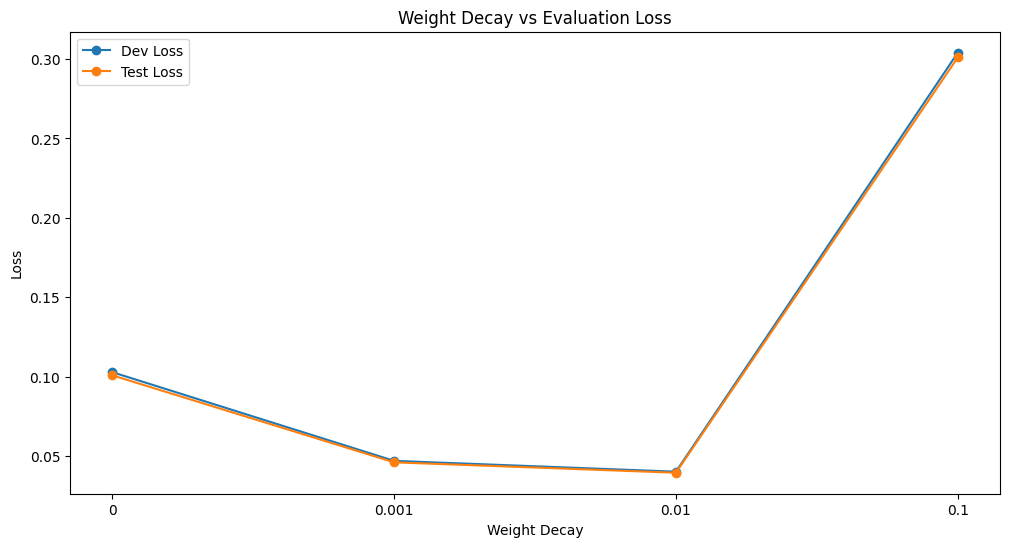

In [24]:
import matplotlib.pyplot as plt

# Define a range of weight decay values to test
weight_decay_values = [0, 0.001, 0.01, 0.1]

# Dictionary to store results
results = {}

# Iterate through weight decay values:
for weight_decay in weight_decay_values:
  print(f"\nTraining with weight decay: {weight_decay}")

  # Training setup
  optimizer = optim.SGD(model.parameters(), lr = 0.1, weight_decay = weight_decay)

  # Training the model
  train_model(model, x1_train, x2_train, ys_train, optimizer)

  # Evaluate the model on dev and test sets
  dev_loss = model.evaluate_model(x1_dev, x2_dev, ys_dev)
  test_loss = model.evaluate_model(x1_test, x2_test, ys_test)

  print(f"Weight Decay: {weight_decay}, Dev Loss: {dev_loss: .4f}, Test Loss: {test_loss: .4f}")

  # Store the results
  results[weight_decay] = {'dev_loss': dev_loss, 'test_loss': test_loss}

# Print the results
print("\nResults:")
for weight_decay, loss in results.items():
    print(f"Weight Decay: {weight_decay}, Dev Loss: {loss['dev_loss']:.4f}, Test Loss: {loss['test_loss']:.4f}")

# Plot the results
weight_decay_values_str = [str(wd) for wd in weight_decay_values]
dev_losses = [results[wd]['dev_loss'] for wd in weight_decay_values]
test_losses = [results[wd]['test_loss'] for wd in weight_decay_values]

plt.figure(figsize=(12, 6))
plt.plot(weight_decay_values_str, dev_losses, label='Dev Loss', marker='o')
plt.plot(weight_decay_values_str, test_losses, label='Test Loss', marker='o')
plt.xlabel('Weight Decay')
plt.ylabel('Loss')
plt.title('Weight Decay vs Evaluation Loss')
plt.legend()
plt.show()
